<font size="6">**Computing Growth-Coupling Algorithms - Basics**</font>

**Requirements**
- Growth-coupling suite (gcOpt) ()
- Escher maps module (https://escher.github.io/#/)
- Activated version of the Gurobi solver (https://www.gurobi.com/)

# Modules and Packages

In [2]:
from growth_coupling_suite.gcOpt_algorithm import gcOpt # main gcOpt module 
from growth_coupling_suite.strain_analysis.strain_design_analysis import StrainDesignAnalyzer as SDA# a custom toolbox for the analysis of strains and designs

import cobra # COBRApy
import escher # Escher maps module

from matplotlib import pyplot as plt
import numpy as np

from pathlib import Path # module for handling paths to directories and files

# Files and Folders

In [3]:
MODEL_PATH = Path(r"Models/")

# Load, Prepare, and Analyze the Metabolic model
Load the **metabolic model** from a file and apply constraints to mimic the desired **environmental conditions, medium, and strain specific features**
## Prepare the model

In [4]:
# load a model of the core metabolism of E. coli K12 MG1655
model = cobra.io.load_json_model(str(MODEL_PATH.joinpath("iML1515Core_exchange.json"))) # load from file
# model = cobra.io.load_model("e_coli_core") # load from BIGG (http://bigg.ucsd.edu/) or BioModels (https://www.ebi.ac.uk/biomodels/) database

# set consraints
model.reactions.get_by_id("EX_glc__D_e").lower_bound = -18 # enable the glucose uptake flux
model.reactions.get_by_id("EX_o2_e").lower_bound = -2 # limit the oxygen uptake flux, microaerobic condition
model.reactions.get_by_id("EX_co2_e").lower_bound = 0 # disable CO2 uptake


Academic license - for non-commercial use only - expires 2022-09-24
Using license file C:\Users\dczie\gurobi.lic


## Add heterologous 1,4-butanediol synthesis pathway

![Butanediol_Pathway](Images/1,4-Butanediol_Synthesis_Pathway.png)

Yim et al. 2011 (http://dx.doi.org/10.1038/nchembio.580)

In [5]:
# add heterologous reactions for the synthesis of 1,4-Butanediol 

# create two pathway alternatives to succinyl semialdehyde
# CoA-dependent succinate semialdehyde dehydrogenase
SUCSALDH = cobra.Reaction(id="SUCSALDH", name="CoA-dependent succinate semialdehyde dehydrogenase", subsystem="Heterologous", lower_bound=0, upper_bound=1000)
SUCSALDH.add_metabolites({
    model.metabolites.get_by_id("succoa_c"): -1,
    model.metabolites.get_by_id("nadh_c"): -1,
    model.metabolites.get_by_id("nad_c"): 1,
    model.metabolites.get_by_id("h_c"): -1,
    model.metabolites.get_by_id("coa_c"): 1,
    model.metabolites.get_by_id("sucsal_c"): 1,
})
# check mass and charge balance
print("Mass balance SUCSALDH:", SUCSALDH.check_mass_balance())

# 2-oxoglutarate decarboxylase
AKGDC = cobra.Reaction(id="AKGDC", name="2-oxoglutarate decarboxylase", subsystem="Heterologous", lower_bound=0, upper_bound=1000)
AKGDC.add_metabolites({
    model.metabolites.get_by_id("akg_c"): -1,
    model.metabolites.get_by_id("h_c"): -1,
    model.metabolites.get_by_id("co2_c"): 1,
    model.metabolites.get_by_id("sucsal_c"): 1,
})
# check mass and charge balance
print("Mass balance AKGDC:", AKGDC.check_mass_balance())


# create metabolite 1,4-Butanediol
btdl_c = cobra.Metabolite(id="14btdl_c", formula="C4H10O2", charge=0, name="1,4-Butanediol", compartment="c") # use BIGG notation
btdl_e = cobra.Metabolite(id="14btdl_e", formula="C4H10O2", charge=0, name="1,4-Butanediol", compartment="e") # itaconate in the extracellular compartment

# create reaction which summarizes the heterologous 1,4-butanediol synthesis pathway from succinyl semialdehde
BTDL_SYN = cobra.Reaction(id="14BTDL_SYN", name="1,4-Butanediol Synthesis", subsystem="Heterologous", lower_bound=0, upper_bound=1000)
BTDL_SYN.add_metabolites({
    model.metabolites.get_by_id("sucsal_c"): -1,
    model.metabolites.get_by_id("nadh_c"): -3,
    model.metabolites.get_by_id("nad_c"): 3,
    model.metabolites.get_by_id("accoa_c"): -1,
    model.metabolites.get_by_id("ac_c"): 1,
    model.metabolites.get_by_id("coa_c"): 1,
    model.metabolites.get_by_id("h_c"): -3,
    btdl_c: 1
})
# check mass and charge balance
print("Mass balance BTDL_SYN:", BTDL_SYN.check_mass_balance())

# create generic transport reaction, exact mechanism is unknown
BTDLtp = cobra.Reaction(id="14BTDLtp", name="1,4-Butanediol transport", subsystem="Heterologous", lower_bound=0, upper_bound=1000)
BTDLtp.add_metabolites({
    btdl_c: -1,
    btdl_e: 1
})

# create exchange reaction for 1,4-butanediol 
EX_14btdl_e = cobra.Reaction(id="EX_14btdl_e", name="1,4-Butanediol exchange", subsystem="Heterologous", lower_bound=0, upper_bound=1000)
EX_14btdl_e.add_metabolites({
    btdl_e: -1
})

# add reactions to the model
model.add_reactions([SUCSALDH, AKGDC, BTDL_SYN, BTDLtp, EX_14btdl_e])

# csave model 
cobra.io.save_json_model(model, str(MODEL_PATH.joinpath("iML1515Core_exchange_14butanediol.json")))

Mass balance SUCSALDH: {}
Mass balance AKGDC: {}
Mass balance BTDL_SYN: {}


## Simulate basic properties

Read LP format model from file C:\Users\dczie\AppData\Local\Temp\tmp5kckovrp.lp
Reading time = 0.01 seconds
: 714 rows, 1752 columns, 6812 nonzeros
Read LP format model from file C:\Users\dczie\AppData\Local\Temp\tmpf3fhn0qd.lp
Reading time = 0.01 seconds
: 714 rows, 1752 columns, 6812 nonzeros
Apply parsed strain design ()...
	No medium composition provided
	No design interventions provided
No solutions in provided dictionary


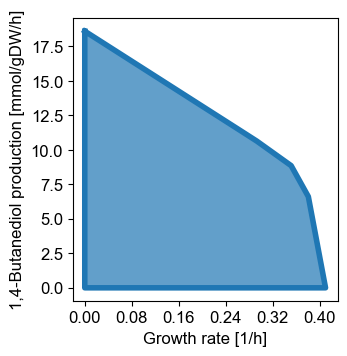

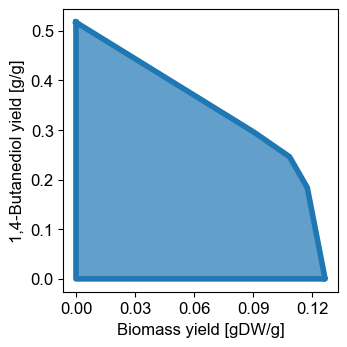

In [6]:
# target_reaction = "EX_succ_e"
target_reaction = "EX_14btdl_e"

# print itaconate production capability
sda = SDA(model=model) # load StrainDesignAnalyzer
# flux space
ax = sda.flux_space_projection(target_rxn=target_reaction,
                               plot=True, dpi=100,
                               xlabel="Growth rate [1/h]", ylabel="1,4-Butanediol production [mmol/gDW/h]",
                               yield_space=False, yield_reference_reaction="EX_glc__D_e")

# yield space
# define factors to transform units to mass scale
unit_transformation_factors = {
    "EX_14btdl_e": model.metabolites.get_by_id("14btdl_e").formula_weight / 1000,
    "EX_glc__D_e": model.metabolites.get_by_id("glc__D_e").formula_weight / 1000
}
ax = sda.flux_space_projection(target_rxn=target_reaction,
                               plot=True, dpi=100,
                               xlabel="Biomass yield [gDW/g]", ylabel="1,4-Butanediol yield [g/g]",
                               unit_transformation_factors=unit_transformation_factors,
                               yield_space=True, yield_reference_reaction="EX_glc__D_e")


In [8]:
# plot in flux map
builder = escher.Builder(
    map_json=str(MODEL_PATH.joinpath("e_coli_central_metabolism_butanediol_escher_map.json")),   
)
builder.model = model

# calculate flux distribution
sol = cobra.flux_analysis.pfba(model)

# show flux distribution in map
builder.reaction_data = sol.fluxes
builder

Builder(reaction_data={'NDPK5': 0.0, 'SHK3Dr': 0.1562455531459291, 'NDPK6': 0.0, 'NDPK8': 0.0, 'DHORTS': -0.13…

# Calculation of Growth-Coupling Strain Designs

![Scheme of the growth-coupling optimization algorithm](Images/gcopt_principle_scheme.png)

For more information about the optimization algorithm and a general investigation of its solutions refer to https://doi.org/10.1186/s12859-019-2946-7

## The configuration file
- The main parameters and options for running gcOpt are set via the configuration file **config_basic.py**
- For parameters not set in the configuration file default values are used

In [9]:
import config_basic as config

## Growth-coupling algorithm setup and execution

- If a model is used for the first time, heterologous reactions are extracted from various metabolic reconstructions (cf. BIGG database)
    - Reaction stoichiometries and metadata is curated by querying KEGG database (https://www.kegg.jp/)
    - If specified in the config file, reaction directions are curated based on thermodynamic considerations using the Equilibrator toolbox (https://equilibrator.weizmann.ac.il/)
    - Building a heterologous reaction database for a model can take a considerable amount of time!
    - The final heterologous reaction database is saved and will automatically be loaded the next time the model is used in gcOpt (the model ID is decisive here) 

In [10]:
# load gcOpt class
GCS = gcOpt.GCOpt(
    model.copy(), # pass the metabolic model
    target_reaction, # specify the reaction which shall be coupled to growth
    config=config, # pass the configuration module
    build_gcopt_problem=True # build the optimization problem (set up and transform the bilevel problem formulation)
)

Read LP format model from file C:\Users\dczie\AppData\Local\Temp\tmp_0q8ldbw.lp
Reading time = 0.01 seconds
: 714 rows, 1752 columns, 6812 nonzeros
Read LP format model from file C:\Users\dczie\AppData\Local\Temp\tmpn6uabdk0.lp
Reading time = 0.01 seconds
: 714 rows, 1752 columns, 6812 nonzeros
Load existing heterologous reaction database model...
	iML1515Core_exchange_hr_database
Read LP format model from file C:\Users\dczie\AppData\Local\Temp\tmpqsqglfpx.lp
Reading time = 0.03 seconds
: 3188 rows, 7274 columns, 34706 nonzeros
Update heterologous reaction database...
	Reactions of iAF692 already in heterologous reaction database
	Reactions of iAF987 already in heterologous reaction database
	Reactions of iAM_Pb448 already in heterologous reaction database
	Reactions of iCHOv1 already in heterologous reaction database
	Reactions of iCN718 already in heterologous reaction database
	Reactions of iCN900 already in heterologous reaction database
	Reactions of iEK1008 already in heterologou

In [11]:
# execute gcOpt
GCS.optimize(
    init_DesignAnalyzer=False # disable solution analysis, will be done manually below
)

Changed value of parameter OutputFlag to 1
   Prev: 0  Min: 0  Max: 1  Default: 1
Changed value of parameter TimeLimit to 300.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter Presolve to 2
   Prev: 0  Min: -1  Max: 2  Default: -1
Changed value of parameter LogFile to Gurobi log files/EX_14btdl_e_log
   Prev:   Default: 
Changed value of parameter Threads to 7
   Prev: 0  Min: 0  Max: 1024  Default: 0
Changed value of parameter NodefileStart to 1.0
   Prev: inf  Min: 0.0  Max: inf  Default: inf
Changed value of parameter NodefileDir to C:\Users\dczie\Desktop\shortcourse_test\GDGA_Shortcourse\Module1_FBA\Part2_Exercise\Growth Coupling Workflows/Results/Butanediol_Basic/callback_solutions/NodeFiles_EX_14btdl_e_i7_k7_a7
   Prev: .  Default: .
Start solving MILP ...
Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (win64)
Thread count: 8 physical cores, 16 logical processors, using up to 7 threads

Consider calling update less frequently.

Optimize a model with 9039

# Analyze Design Solutions
## Summarize growth-coupling design solutions

In [11]:
# load Strain Design Analyzer
sda = SDA()
# load results files, all files in the specified folder will be loaded
sda.load_strain_design_files_from_dir(
    config.output_dir, # specify path to result files
    eval_gpr=config.eval_gpr # consider Gene-Protein-Reaction relations for the curation of design solutions 
    )

# Get a summary of computed growth-coupled designs 
sda.growth_coupling_summary(
    results_filename="gcOpt_summary_result",
    results_dir=config.output_dir,
    determine_significant_designs=True, # duplicate solutions are disrearded,
                                        # design objects (deletions, add-ins, etc.) that do not contribute to the coupling are stripped from solutions
    save_results=True, # save results (Strain Design Analyzer instance and summary in an Excel file)
    save_flux_space_plots=True, # flux space plots are saved for each (significant) design solution
    eval_gpr=config.eval_gpr
    )

Read LP format model from file C:\Users\dczie\AppData\Local\Temp\tmpb_hxd1eo.lp
Reading time = 0.02 seconds
: 1469 rows, 3668 columns, 17182 nonzeros
Read LP format model from file C:\Users\dczie\AppData\Local\Temp\tmpiqvv7smn.lp
Reading time = 0.01 seconds
: 714 rows, 1752 columns, 6812 nonzeros
Load file: C:\Users\dczie\Desktop\shortcourse_test\Strainware-m\Short Courses\Growth Coupling Workflows\Results\Butanediol_Basic\gcOpt_solution_dict_EX_14btdl_e_i7_k7_a7.pickle
Read LP format model from file C:\Users\dczie\AppData\Local\Temp\tmppvktlure.lp
Reading time = 0.01 seconds
: 714 rows, 1752 columns, 6812 nonzeros
Read LP format model from file C:\Users\dczie\AppData\Local\Temp\tmpg623tedo.lp
Reading time = 0.01 seconds
: 714 rows, 1752 columns, 6812 nonzeros
	Duplicate design solutions encountered
Read LP format model from file C:\Users\dczie\AppData\Local\Temp\tmpdgrghpms.lp
Reading time = 0.01 seconds
: 718 rows, 1752 columns, 6812 nonzeros
Read LP format model from file C:\Users\d

c:\users\dczie\desktop\shortcourse_test\py38_gcs_env\lib\site-packages\pandas\core\internals\blocks.py:938: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr_value = np.asarray(value)


Reverse previous strain design...
Apply parsed strain design (design_2)...
	Set medium composition
	Set design interventions
6.04029436644004
Reverse previous strain design...
Apply parsed strain design (design_3)...
	Set medium composition
	Set design interventions
6.0495619729168215
Reverse previous strain design...
Apply parsed strain design (design_4)...
	Set medium composition
	Set design interventions
9.395622476663549
Reverse previous strain design...
Apply parsed strain design (design_5)...
	Set medium composition
	Set design interventions
0.824881158315856


c:\users\dczie\desktop\shortcourse_test\py38_gcs_env\lib\site-packages\growth_coupling_suite-0.0.1-py3.8.egg\growth_coupling_suite\strain_analysis\strain_design_analysis.py:1128: UserWarning: No significant design solutions: ['HEX7', 'EDD', 'ALCD2x', 'PGI', 'LDH_D']
  warn("No significant design solutions: " + str(list(sol._design_solution["interventions"].keys())),


Reverse previous strain design...
Apply parsed strain design (design_6)...
	Set medium composition
	Set design interventions
0.8277246284859245
Reverse previous strain design...
Apply parsed strain design (design_7)...
	Set medium composition
	Set design interventions
0.8452171801303031
Reverse previous strain design...
Apply parsed strain design (design_8)...
	Set medium composition
	Set design interventions
0.1907630977163599
Reverse previous strain design...
Apply parsed strain design (design_9)...
	Set medium composition
	Set design interventions
0.8248811583160391
Reverse previous strain design...
Apply parsed strain design (design_10)...
	Set medium composition
	Set design interventions
3.60989424377123
Reverse previous strain design...
Apply parsed strain design (design_11)...
	Set medium composition
	Set design interventions
6.2570989590391894
Reverse previous strain design...
Apply parsed strain design (design_12)...
	Set medium composition
	Set design interventions
0.19110234

,filename,key_in_file,objective_value,number_interventions,number_genetic_interventions,interventions,interventions_excluded,genetic_interventions,unique_genetic_interventions,carbon_uptake_bounds,mutables_flux_at_maximum_growth,coupling_strength,max_growth_rate,target_flux_at_maximum_growth,score,biomass_precursor_auxotrophy
design_1,gcOpt_solution_dict_EX_14btdl_e_i7_k7_a7.pickle,design_0,3.625034,6,14,GLYCL;XYLI2;PGI;EDA;PFL;CYSTA__hr,PSERT,"b0116,b2905,b2903,b2904;b3565;b4025;b1850;b395...",b0116;b2905;b2903;b2904;b3565;b4025;b1850;b395...,EX_glc__D_e:-18,"GLYCL:0.0,XYLI2:0.0,PGI:0.0,EDA:0.0,PFL:0.0,CY...",0.192363,0.158245,10.739341,0.450566,
design_2,gcOpt_solution_dict_EX_14btdl_e_i7_k7_a7.pickle,design_1,6.040299,6,14,GLYCL;XYLI2;PGI;EDA;PSERT;PFL,CYSTA__hr,"b0116,b2905,b2903,b2904;b3565;b4025;b1850;b090...",b0116;b2905;b2903;b2904;b3565;b4025;b1850;b090...,EX_glc__D_e:-18,"GLYCL:0.0,XYLI2:0.0,PGI:0.0,EDA:0.0,PSERT:0.0,...",0.180836,0.10777,10.007299,0.370888,
design_3,gcOpt_solution_dict_EX_14btdl_e_i7_k7_a7.pickle,design_3,6.040294,6,14,GLYCL;XYLI2;PGI;EDA;PFL;PSP_L,CYSTA__hr,"b0116,b2905,b2903,b2904;b3565;b4025;b1850;b395...",b0116;b2905;b2903;b2904;b3565;b4025;b1850;b395...,EX_glc__D_e:-18,"GLYCL:0.0,XYLI2:0.0,PGI:0.0,EDA:0.0,PFL:0.0,PS...",0.180836,0.10777,10.007299,0.370888,
design_4,gcOpt_solution_dict_EX_14btdl_e_i7_k7_a7.pickle,design_4,3.631984,6,14,GLYCL;XYLI2;PGI;EDA;G3PD2;PFL,PSP_L,"b0116,b2905,b2903,b2904;b3565;b4025;b1850;b360...",b0116;b2905;b2903;b2904;b3565;b4025;b1850;b360...,EX_glc__D_e:-18,"GLYCL:0.0,XYLI2:0.0,PGI:0.0,EDA:0.0,G3PD2:0.0,...",0.192362,0.158042,10.740957,0.450304,
design_5,gcOpt_solution_dict_EX_14btdl_e_i7_k7_a7.pickle,design_6,5.834981,6,16,GLYCL;XYLI2;PGI;EDA;PFL;ACKr,PSP_L,"b0116,b2905,b2903,b2904;b3565;b4025;b1850;b395...",b0116;b2905;b2903;b2904;b3565;b4025;b1850;b395...,EX_glc__D_e:-18,"GLYCL:0.0,XYLI2:0.0,PGI:0.0,EDA:0.0,PFL:0.0,AC...",0.317399,0.158245,10.952372,0.61125,
design_6,gcOpt_summary_result_dict.pickle,design_8,0.824881,5,6,HEX7;EDD;ALCD2x;PGI;LDH_D,G3PD2,"b0394;b1851;b1478,b1241;b4025;b1380",b0394;b1851;b1478;b1241;b4025;b1380,EX_glc__D_e:-18,"HEX7:0.0,EDD:0.0,ALCD2x:0.0,PGI:0.0,LDH_D:0.0",0.151101,0.221446,8.125883,0.532993,
design_7,gcOpt_summary_result_dict.pickle,design_10,0.190763,5,11,HEX7;PFL;ALCD2x;PGI;LDH_D,CYSTA__hr,"b0394;b3952,b0903,b3951,b2579,b0902,b3114;b147...",b0394;b3952;b0903;b3951;b2579;b0902;b3114;b147...,EX_glc__D_e:-18,"HEX7:0.0,PFL:0.0,ALCD2x:0.0,PGI:0.0,LDH_D:0.0",0.141127,0.185732,9.071848,0.467631,
design_8,gcOpt_summary_result_dict.pickle,design_12,3.609894,4,9,HEX7;PFL;EDD;PGI,ALCD2x;CYSTA__hr,"b0394;b3952,b0903,b3951,b2579,b0902,b3114;b185...",b0394;b3952;b0903;b3951;b2579;b0902;b3114;b185...,EX_glc__D_e:-18,"HEX7:0.0,PFL:0.0,EDD:0.0,PGI:0.0",0.192024,0.158384,10.746822,0.582015,
design_9,gcOpt_summary_result_dict.pickle,design_15,3.609894,5,10,HEX7;PFL;EDD;PGI;LDH_D,ALCD2x,"b0394;b3952,b0903,b3951,b2579,b0902,b3114;b185...",b0394;b3952;b0903;b3951;b2579;b0902;b3114;b185...,EX_glc__D_e:-18,"HEX7:0.0,PFL:0.0,EDD:0.0,PGI:0.0,LDH_D:0.0",0.192024,0.158384,10.952622,0.50132,
design_10,gcOpt_summary_result_dict.pickle,design_25,5.810758,5,11,HEX7;PFL;EDD;PGI;PTAr,LDH_D,"b0394;b3952,b0903,b3951,b2579,b0902,b3114;b185...",b0394;b3952;b0903;b3951;b2579;b0902;b3114;b185...,EX_glc__D_e:-18,"HEX7:0.0,PFL:0.0,EDD:0.0,PGI:0.0,PTAr:0.0",0.31646,0.158384,10.952622,0.679348,


## Analyze a particular design solution
- Observe the summary of design solutions in the Excel file to pick a promising design solution (ID in the first column)

Reverse previous strain design...
Apply parsed strain design (design_6)...
	Set medium composition
	Set design interventions


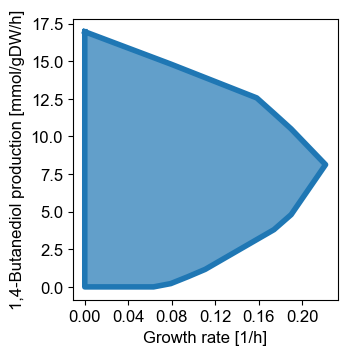

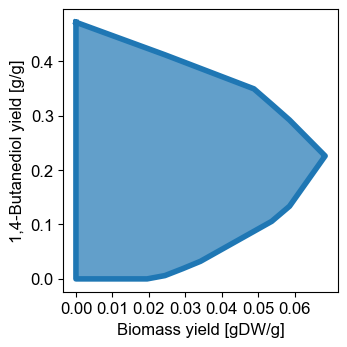

In [12]:
design_id = "design_6" # choose a strain design
# load design
getattr(sda.solutions, design_id).load()
# print flux space projections
ax = sda.flux_space_projection(target_rxn=target_reaction,
                               plot=True, dpi=100,
                               xlabel="Growth rate [1/h]", ylabel="1,4-Butanediol production [mmol/gDW/h]",
                               yield_space=False, yield_reference_reaction="EX_glc__D_e")

ax = sda.flux_space_projection(target_rxn=target_reaction,
                               plot=True, dpi=100,
                               xlabel="Biomass yield [gDW/g]", ylabel="1,4-Butanediol yield [g/g]",
                               unit_transformation_factors=unit_transformation_factors,
                               yield_space=True, yield_reference_reaction="EX_glc__D_e")

In [13]:
# plot in flux map

builder = escher.Builder(
    map_json=str(MODEL_PATH.joinpath("e_coli_central_metabolism_butanediol_escher_map.json")),   
)
builder.model = sda.model # parse model of strain design

# calculate flux distribution by parsimonous flux balance analysis
sol = cobra.flux_analysis.pfba(sda.model)

# show flux distribution in map
builder.reaction_data = sol.fluxes
builder

Builder(reaction_data={'NDPK5': 0.0, 'SHK3Dr': 0.08439721377844672, 'NDPK6': 0.0, 'NDPK8': 0.0, 'DHORTS': -0.0…